# Example on CASToR reconstruction framework
This is an example of openSSS directly linked to CASToR.  
It works by directly reading the datafile within Python:
1. To obtain the prompts sinograms per TOF bin
2. To inject the scalled scatters into the datafile.

In [ ]:
import os
import numpy as np
from PIL import Image # to save image
import subprocess
import matplotlib.pyplot as plt

from openSSS.Support import ReadParameters
from openSSS.Utils import PrepareImages, ComputePhisicalDimensions
from openSSS.IO import CreateDirectories, GeneratePrompts

from openSSS.Geometry import PrepareGeometryAndSinograms
from openSSS.DataReduction import SumLORsCounts
from openSSS.TailsMask import GenerateTailsMask

from openSSS.SingleScatterSimulationTOF import SingleScatterSimulationTOF
from openSSS.Interpolation import InterpolateScatters
from openSSS.Scaling import ScaleScattersToPrompts

from Timber import Headerfile, Datafile

## Settings
The parameters of openSSS are fully customizable. It is advisible to edit all the values in a seperate textfile, using the provided example as reference.

In [2]:
# Path to parameter file and number of iterations for the reconstruction (after the initial non-scatter-corrected iteration)
params = './DemoData/parameters_Demo.txt'
totalIterations = 1

In [ ]:
# Load parameters from parameter file
parameters = ReadParameters(params)

folderImages = parameters['FolderImages']
folderScatters = parameters['FolderScatters']

Path2Data = parameters['Path2Data']
Path2Result = parameters['Path2Result']
Path2Datafile = parameters['Path2Datafile']

print(f"Data path is defined as {Path2Data}")
print(f"Save path is defined as {Path2Result}")
print(f"Datafile path is defined as {Path2Result}")

Data path is defined as Data
Save path is defined as DemoData
Datafile path is defined as DemoData


## Load scanner information

In [ ]:
# Reads the CASToR Headerfile (.cdh)
DatafileName = parameters['DatafileName']
ExperimentName = DatafileName[:-7] # filters _df.Cdh from DatafileName
header = Headerfile.ReadHeaderFile(os.path.join(Path2Datafile, DatafileName))

# Obtains scanner name from datafile
ScannerName = header['scanner_name']

# Create directories to save files to
targetFolder = os.path.join(Path2Result, 'Scatters')
CreateDirectories(targetFolder, folderImages, folderScatters, params)

Used parameters saved to DemoData/Scatters


In [5]:
# Parameters for SSS simulation
NrRingsSimulated = parameters['NrRingsSimulated']
NrDetectorsSimulated = parameters['NrDetectorsSimulated']
SampleStep = np.array([parameters['SampleStep_x'], parameters['SampleStep_y'], parameters['SampleStep_z']])
AccelerationFactor = parameters['AccelerationFactor']

EnergyThreshold = parameters['EnergyThreshold']
EnergyResolution = parameters['EnergyResolution']

TOFRange = parameters['TOFRange']
TOFbins = parameters['TOFbins']
TOFResolution = header['tof_resolution']

MRD = parameters['MRD']
SavePath = os.path.join(targetFolder, folderScatters) # Folder to save the scatter estimation

# Create Mash and Span according to whether we apply data reduction
DataReduction = parameters['DataReduction']
if DataReduction == False:
    Mash = 1
    Span = 1
else:
    Mash = parameters['AngularMashing']
    Span = parameters['AxialMashing']
    print('Data reduction is applied, with mash {} and span {}'.format(Mash, Span))

Data reduction is applied, with mash 2 and span 19


In [ ]:
# Loads the geometry from the CASToR .glut file and calculates all required LUT for the LOR to sinogram encoding
Geometry, NormalVectors, DetectorSize, LORCoordinates, SinogramIndex, LookUpTable, extendedGeometry, extendedNormalVectors, SinogramCounts, DetectorShift = \
    PrepareGeometryAndSinograms(ScannerName, Mash, Span, MRD, Path2Data)

Apply mash 2
Apply Span 19


Geometry is organized as rings (80), transaxial crystals (380) and 3D position


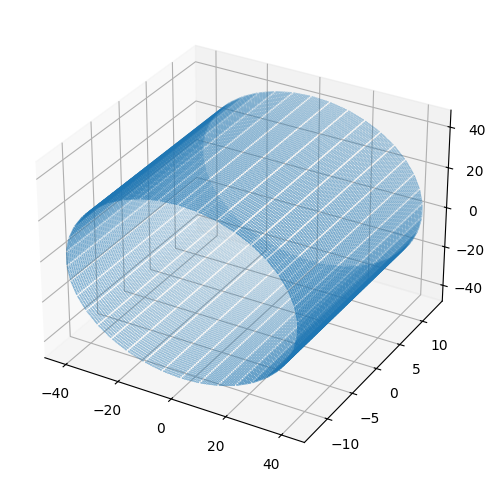

In [7]:
# Visualization of the geometry of the scanner
print('Geometry is organized as rings ({}), transaxial crystals ({}) and {}D position'.format(*Geometry.shape))

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.scatter(Geometry[:,:,0].flatten(), Geometry[:,:,2].flatten(), Geometry[:,:,1].flatten(), s=0.1)
plt.show()

In [8]:
# Calculates the dimensions for the cropped and downscaled maps used for scatter estimation
DesiredScale = np.array([parameters['DesiredDimensions_x'], parameters['DesiredDimensions_y'], parameters['DesiredDimensions_z']])
DeviceSize = (np.max(Geometry, axis=(0,1)) - np.min(Geometry, axis=(0,1)))*10
DeviceDimensions = (DeviceSize//DesiredScale).astype(int)
DeviceSize = DeviceDimensions * DesiredScale

print('Device size is {}cm, which for the desired scale {}cm/voxel, corresponds to {} voxels'.format(DeviceSize, DesiredScale, DeviceSize))

Device size is [840 840 248]cm, which for the desired scale [8 8 8]cm/voxel, corresponds to [840 840 248] voxels


## Prepare activity & attenuation

In [9]:
# Import attenuation map and table
attenuationFile = os.path.join(Path2Datafile, parameters['MuMapName'])
AttenuationTable = np.load(f'./openSSS/AttenuationTable_AttenuationTable.npy')

In [ ]:
# Load activity map if exists, using the filename structure of CASToR
activityFile = os.path.join(Path2Datafile, f'output-{ExperimentName}-step1_it1.hdr')

# Else reconstruct with CASToR for 1 iteration without scatter correction
if not os.path.isfile(activityFile):
    command = [f'bash ./CASToR_recon.sh {ExperimentName} 1']
    processes = [subprocess.Popen(cmd, shell=True, cwd=Path2Datafile) for cmd in command]
    for proc in processes:
        proc.wait()

In [11]:
# Crop and downscaled the maps
ActivityMapDownscaled, AttenuationMapDownscaled, DesiredSize, DesiredDimensions = PrepareImages(activityFile, attenuationFile, [None, None, DeviceSize[2]], DesiredScale)
ImageSize, FittingSize = ComputePhisicalDimensions(DesiredSize, DeviceSize)

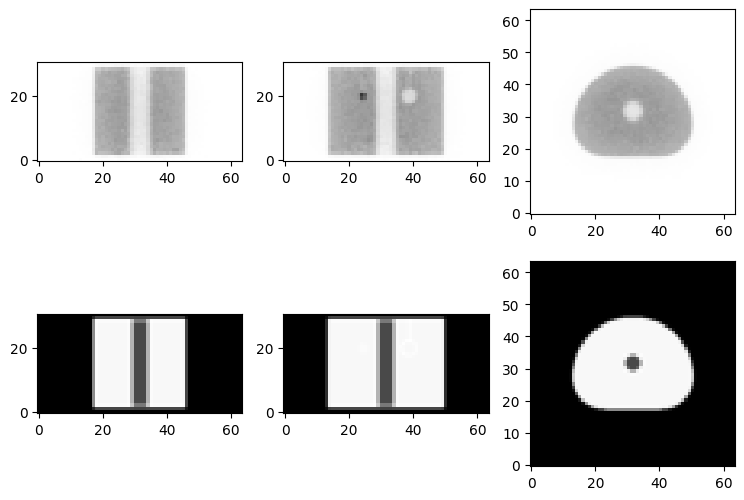

In [12]:
# Visualization of the cropped maps
fig, ax = plt.subplots(2,3, figsize=(9,6))

for index, map in enumerate([ActivityMapDownscaled, AttenuationMapDownscaled]):
    cmap = 'binary' if index==0 else 'gray'
    vmax = np.max(map)
    ax[index,0].imshow(map[DesiredDimensions[0]//2,:,:].transpose(1,0), vmax=vmax, cmap=cmap, origin='lower')
    ax[index,1].imshow(map[:,DesiredDimensions[1]//2,:].transpose(1,0), vmax=vmax, cmap=cmap, origin='lower')
    ax[index,2].imshow(map[:,:,DesiredDimensions[2]//2].transpose(1,0), vmax=vmax, cmap=cmap, origin='lower')

plt.show()

## Generates the tails mask for the scatter scaling

In [13]:
# It is automatically saved in memory too
AttenuationMask = GenerateTailsMask(SavePath, ActivityMapDownscaled, AttenuationMapDownscaled, ImageSize,\
                                    Geometry, extendedGeometry, LORCoordinates, SinogramIndex, AccelerationFactor)

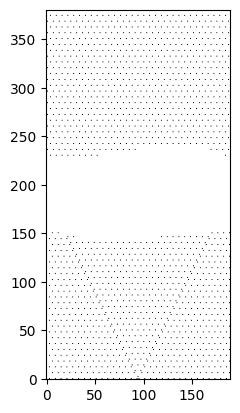

In [14]:
# Visualization of the tail mask
fig = plt.plot(figsize=(4,2))

SinogramSize = AttenuationMask.shape
cmap = 'binary'
vmax = np.max(AttenuationMask)

plt.imshow(AttenuationMask[:,:,SinogramSize[2]//2], vmax=vmax, cmap=cmap, origin='lower')
plt.show()

## Load the prompts

In [ ]:
# Generates a LUT that gives how many LORs contribute to each sinogram coordinate, in the case of applying data reduction
sumLORCounts = SumLORsCounts(Geometry, LookUpTable, SinogramIndex, Mash, Span, SinogramCounts.shape[0])

In [16]:
# Generates the sinograms for the prompts, if it did not do so already
GeneratePrompts(SavePath, Path2Datafile, DatafileName, LORCoordinates, SinogramIndex, LookUpTable, TOFbins, TOFRange, Span, Mash, Shift=DetectorShift)

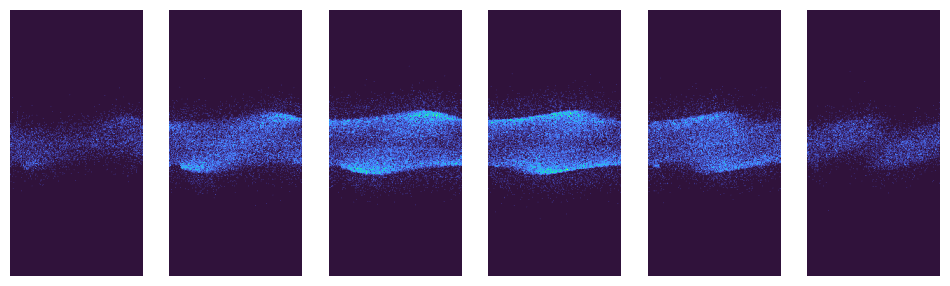

In [17]:
# Visualize the generated prompts, by first loading them into memory
Prompts = np.load(f'{SavePath}/PromptsSinogram.npz')['arr_0'] if not DataReduction else np.load(f'{SavePath}/PromptsSinogramMashed.npz')['arr_0']

fig, ax = plt.subplots(1,TOFbins, figsize=(12,6))

cmap = 'turbo'
vmax = np.max(Prompts)

for bin in range(TOFbins):
    ax[bin].imshow(Prompts[:,:,SinogramSize[2]//2,bin], vmax=vmax, cmap=cmap, origin='lower')
    ax[bin].set_axis_off()
    
plt.show()
del Prompts

## Performs the scatter estimation  
Each step of SSS has been seperated in its own function for ease of understanding and adapting

### Estimation for sampled subset of rings and detectors

In [18]:
# Outputs the estimated scatters for only the sampled rings and detectors combination
SampledScatters = SingleScatterSimulationTOF(ActivityMapDownscaled, AttenuationMapDownscaled, ImageSize, Geometry, LORCoordinates,
                                                NormalVectors, DetectorSize, AttenuationTable, EnergyResolution, EnergyThreshold, NrRingsSimulated,
                                                NrDetectorsSimulated, SampleStep, TOFResolution, TOFRange, TOFbins, SavePath)

Start Scattering Simulation
Time for SSS: 25.54 seconds


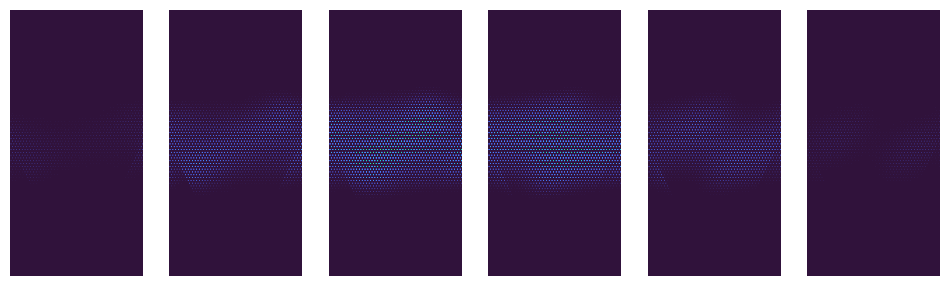

In [19]:
# Visualization of sampled scatters for each TOF bin
fig, ax = plt.subplots(1,TOFbins, figsize=(12,6))

SampledSize = SampledScatters.shape[1:]
cmap = 'turbo'
vmax = np.max(SampledScatters)

for bin in range(TOFbins):
    ax[bin].imshow(SampledScatters[bin,:,:,SampledSize[2]//2], vmax=vmax, cmap=cmap, origin='lower')
    ax[bin].set_axis_off()
    
plt.show()

### Interpolation to the full sinogram-space

In [20]:
# Interpolates the sampled scatters to the full sinogram space (only outputs summed for all TOF bins, individually are saved to disk)
InterpolatedScatters = InterpolateScatters(SampledScatters, Geometry.shape[0], NrRingsSimulated, Geometry.shape[1], NrDetectorsSimulated,
                                            LORCoordinates, SinogramIndex, SavePath, Span > 1)

Start Interpolating with data reduction
Interpolate all bins
Bin 0 took 2.84 seconds
Bin 1 took 5.43 seconds
Bin 2 took 5.49 seconds
Bin 3 took 5.39 seconds
Bin 4 took 5.51 seconds
Bin 5 took 5.45 seconds
Time for Interpolation: 36.69 seconds


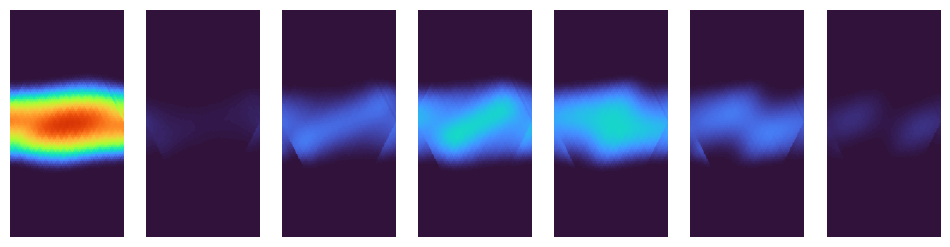

In [21]:
# Visualization of interpolated scatters for summed plus each TOF bin
fig, ax = plt.subplots(1,TOFbins+1, figsize=(12,6))

cmap = 'turbo'
vmax = np.max(InterpolatedScatters)

for bin in range(TOFbins+1):
    ScattersBin = np.load(f'{SavePath}/SSS_mashed_bin{bin -1}.npz')['arr_0'] if bin > 0 else InterpolatedScatters
    ax[bin].imshow(ScattersBin[:,:,SinogramSize[2]//2], vmax=vmax, cmap=cmap, origin='lower')
    ax[bin].set_axis_off()

plt.show()
del ScattersBin

### Scaling of scatters to the prompts

In [22]:
# Scales the interpolated scatters (loading them per bin from disk)
ScaleFactors = ScaleScattersToPrompts(SinogramIndex, LORCoordinates, SavePath,
                                      DesiredDimensions, FittingSize, Geometry, extendedGeometry,
                                      AccelerationFactor, Span > 1, sumLORCounts)

Scaling for all bins
Bin 0 took 7.35 seconds
Bin 1 took 4.91 seconds
Bin 2 took 4.91 seconds
Bin 3 took 4.89 seconds
Bin 4 took 4.92 seconds
Bin 5 took 5.01 seconds
Time for Scaling: 31.99 seconds


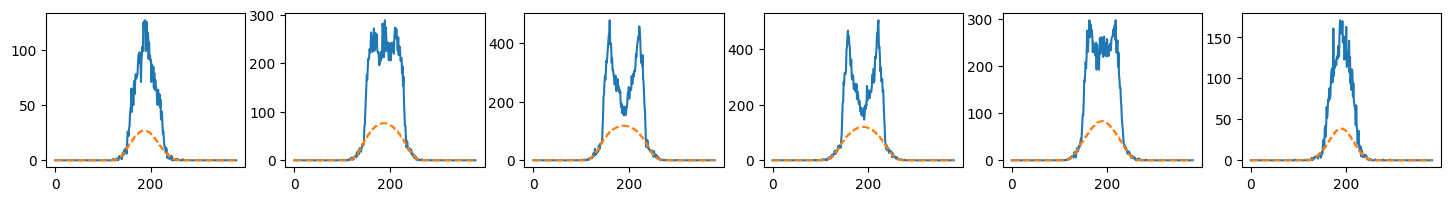

In [23]:
# Visualize the prompts with the scaled estimated scatters, summed on the sinogram radial direction
Prompts = np.load(f'{SavePath}/PromptsSinogram.npz')['arr_0'] if not DataReduction else np.load(f'{SavePath}/PromptsSinogramMashed.npz')['arr_0']

fig, ax = plt.subplots(1,TOFbins, figsize=(18,2))

for bin in range(TOFbins):
    ScattersBin = np.load(f'{SavePath}/SSS_mashed_bin{bin}.npz')['arr_0'] * sumLORCounts
    PromptsBin = Prompts[...,bin]

    ax[bin].plot(np.sum(PromptsBin[:,:,SinogramSize[2]//2], axis=1))
    ax[bin].plot(np.sum(ScattersBin[:,:,SinogramSize[2]//2] * ScaleFactors[bin], axis=1), '--')
    
plt.show()
del Prompts
del PromptsBin
del ScattersBin

### Injection of scatters in CASToR datafile

In [ ]:
# Inject scatter to CASToR datafile
Datafile.InjectScatters(Path2Datafile, DatafileName, LORCoordinates, SinogramIndex, SavePath, LookUpTable, Span > 1, TOFRange, mash=Mash, Shift=DetectorShift)

### Reconstruction with scatter correction

In [ ]:
# Runs the reconstruction with the estimated scatters injected in the new CASToR datafile
command = [f'bash ./CASToR_recon.sh {ExperimentName} {i+2}']
processes = [subprocess.Popen(cmd, shell=True, cwd=Path2Datafile) for cmd in command]
for proc in processes:
    proc.wait()

In [37]:
# Loads the new activity map
activityFile = os.path.join(Path2Datafile, f'output-{ExperimentName}-step2_it1.hdr')
NewActivityMapDownscaled, _, _, _ = PrepareImages(activityFile, attenuationFile, [None, None, DeviceSize[2]], DesiredScale)

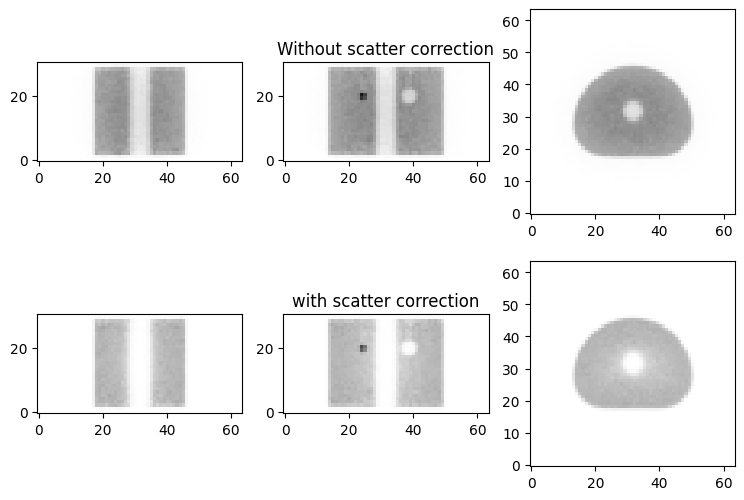

In [40]:
# Visualize the activity map before and after scatter correction (one iteration)
fig, ax = plt.subplots(2,3, figsize=(9,6))

vmax = np.max(NewActivityMapDownscaled)
cmap = 'binary'

for index, map in enumerate([ActivityMapDownscaled, NewActivityMapDownscaled]):
    ax[index,0].imshow(map[DesiredDimensions[0]//2,:,:].transpose(1,0), vmax=vmax, cmap=cmap, origin='lower')
    ax[index,1].imshow(map[:,DesiredDimensions[1]//2,:].transpose(1,0), vmax=vmax, cmap=cmap, origin='lower')
    ax[index,2].imshow(map[:,:,DesiredDimensions[2]//2].transpose(1,0), vmax=vmax, cmap=cmap, origin='lower')

    title = 'Without scatter correction (1 iteration)' if index == 0 else 'with scatter correction'
    ax[index,1].set_title(title)

plt.show()